<a href="https://colab.research.google.com/github/amilliongoals/Customer-Service-Query-AI/blob/main/Cleaned_Customer_Service_Query_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install openai==0.28.1
!pip install scikit-learn
!pip install tiktoken
!pip install mwclient
!pip install mwparserfromhell
!pip install utils


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 1.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires tiktoken, which is not installed.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 18.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.0/191.0 kB 3.5 MB/s eta 0:00:00


In [4]:
import os
import pandas as pd
import openai
import numpy as np
from ast import literal_eval
import matplotlib.pyplot as plt
import urllib
import re
import tiktoken
import mwclient
import mwparserfromhell
import re
import tiktoken
import textwrap as tr
from typing import List, Optional
import plotly.express as px
from scipy import spatial
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import average_precision_score, precision_recall_curve
from tenacity import retry, stop_after_attempt, wait_random_exponential
from google.colab import userdata

key = userdata.get('OPENAI_API_KEY')
secret_value_0 = userdata.get('OPENAI_API_KEY')
encoding= tiktoken.get_encoding("cl100k_base")
EMBEDDING_MODEL = "text-embedding-ada-002"
GPT_MODEL = "gpt-3.5-turbo"
embedding_model = "text-embedding-ada-002"
embedding_encoding = "cl100k_base"
max_tokens = 8000


In [5]:
data0= 'https://raw.githubusercontent.com/amilliongoals/Customer-Service-Query-AI/main/data/3rdpartyreturn.md'
data1 = 'https://raw.githubusercontent.com/amilliongoals/Customer-Service-Query-AI/main/data/Return%20Policy.md'
data2 = 'https://raw.githubusercontent.com/amilliongoals/Customer-Service-Query-AI/main/data/amzstylerturn.md'
data3 = 'https://raw.githubusercontent.com/amilliongoals/Customer-Service-Query-AI/main/data/fashion%20returns.md'
data4 = 'https://raw.githubusercontent.com/amilliongoals/Customer-Service-Query-AI/main/data/gift%20return%20w%20reciept.md'
data5 = 'https://raw.githubusercontent.com/amilliongoals/Customer-Service-Query-AI/main/data/gift%20return.md'
data6 ='https://raw.githubusercontent.com/amilliongoals/Customer-Service-Query-AI/main/data/globalreturn.md'
data7 = 'https://raw.githubusercontent.com/amilliongoals/Customer-Service-Query-AI/main/data/hub%20return.md'
data8 = 'https://raw.githubusercontent.com/amilliongoals/Customer-Service-Query-AI/main/data/internatonal%20returns.md'
data9 = 'https://raw.githubusercontent.com/amilliongoals/Customer-Service-Query-AI/main/data/mistakenreturns.md'
data10 = 'https://raw.githubusercontent.com/amilliongoals/Customer-Service-Query-AI/main/data/nonrefundable%20items.md'
data11 = 'https://raw.githubusercontent.com/amilliongoals/Customer-Service-Query-AI/main/data/return%20costs.md'
data12 = 'https://raw.githubusercontent.com/amilliongoals/Customer-Service-Query-AI/main/data/returncancel.md'

dataset = [data0,data1,data2,data3,data4,data5,data6,data7,data8,data9,data10,data11,data12]
textfile=[0]*len(dataset)

i=0
while i<len(dataset):
   textfile[i]=urllib.request.urlopen(dataset[i]).read()
   i=i+1
text_df=pd.DataFrame(textfile)
text_df


df= pd.DataFrame({"web-url":dataset, "text":textfile})

df['web-url'] = df['web-url'].str.replace('https://raw.githubusercontent.com/amilliongoals/Customer-Service-Query-AI/main/data/',"").str.replace('.md',"")

df['text']=df['text'].str.decode('utf-8')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-5-ccec6d1db099>:28: FutureWarning: The default value of regex will change from True to False in a future version.
  df['web-url'] = df['web-url'].str.replace('https://raw.githubusercontent.com/amilliongoals/Customer-Service-Query-AI/main/data/',"").str.replace('.md',"")


In [6]:
def clean_text(text):
  text = text.lower()
  text = text.replace("\n", " ")
  text = text.replace("-", "")
  text = text.replace("  ", " ")
  text = text.replace("   "," ")
  text = text.replace("*", "")
  text = text.replace("\\", "")
  text = text.replace(".com", "")
  text=  re.sub(r'http\S+', '', text)
  return text

df['text']=df['text'].apply(clean_text)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
df['Token_n']=df.text.apply(lambda x: len(encoding.encode(x)))
print(df)
token_sum = df['Token_n'].sum()
percent_util = df['Token_n'].sum() /8000 *100
print("\n\n",token_sum, 'out of 8000 tokens', percent_util,'% of tokens used')
if percent_util > 100:
  print("\nTry cleaning data more, if unable will handle in chunking :)")
else:
  print("\nTokens is within range")

                        web-url  \
0                3rdpartyreturn   
1               Return%20Policy   
2                 amzstylerturn   
3             fashion%20returns   
4   gift%20return%20w%20reciept   
5                 gift%20return   
6                  globalreturn   
7                  hub%20return   
8        internatonal%20returns   
9               mistakenreturns   
10        nonrefundable%20items   
11               return%20costs   
12                 returncancel   

                                                 text  Token_n  
0   # returns to thirdparty sellers amazon custome...      436  
1   # about our returns policies amazon customer s...     3615  
2   # returning an amazon style purchase amazon cu...      400  
3   # free returns on fashion items amazon custome...      926  
4   # return a gift using a gift receipt amazon cu...       79  
5   # return a gift amazon customer service the re...      438  
6   # amazon global store returns amazon customer ... 

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
def string_splitter_5000(text:str, max_tokens:int):
  sentences= text.split(". ")
  chunks= []
  chunk=""
  n_chunk_tokens= 0
  for sentence in sentences:
        n_sentence_tokens = len(encoding.encode(" "+ sentence))
        if n_sentence_tokens > max_tokens:
          print("bad sentence:", n_sentence_tokens, "\n", sentence)

        if n_sentence_tokens + n_chunk_tokens > max_tokens:
          chunks.append(chunk)
          chunk=""
          n_chunk_tokens = 0

        chunk +=" " + sentence
        n_chunk_tokens=len(encoding.encode(chunk))
  if chunk:
    chunks.append(chunk)
  return chunks

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
embedding_texts=[]
MAX_TOKENS = 600
for idx, row in df.iterrows():
  if row.Token_n > MAX_TOKENS:
    splitted_string = string_splitter_5000(row.text, max_tokens= MAX_TOKENS )

    for t in splitted_string:
        embedding_texts.append(t)
  else:
        embedding_texts.append(row.text)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


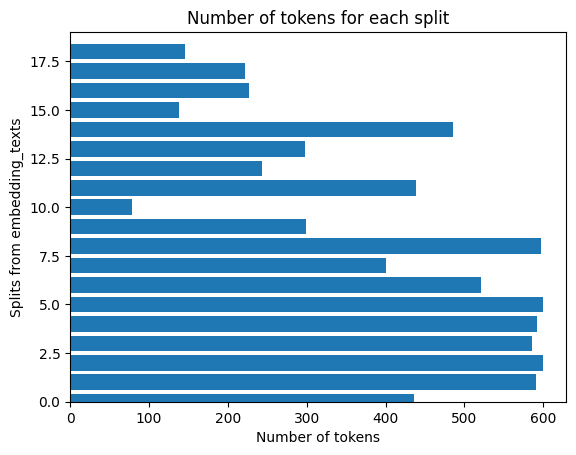

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.barh(range(len(embedding_texts)), [len(encoding.encode(t)) for t in embedding_texts])
ax.set_title("Number of tokens for each split")
ax.set_xlabel("Number of tokens")
ax.set_ylabel("Splits from embedding_texts")
ax.set_ylim(0, 19)
plt.show()

In [11]:
def get_embedding(text: str, engine="text-similarity-davinci-001", **kwargs) -> List[float]:
    text = text.replace("\n", " ")
    return openai.Embedding.create(input=[text], engine=engine, **kwargs)["data"][0]["embedding"]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
openai.api_key = key
df["embedding"] = df.text.apply(lambda x: get_embedding(x, engine=embedding_model))

df=df[['text', 'embedding','Token_n']].copy()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
#manual port of distances_from_embedding
def distances_from_embeddings(
    query_embedding: List[float],
    embeddings: List[List[float]],
    distance_metric="cosine",
) -> List[List]:
    """Return the distances between a query embedding and a list of embeddings."""
    distance_metrics = {
        "cosine": spatial.distance.cosine,
        "L1": spatial.distance.cityblock,
        "L2": spatial.distance.euclidean,
        "Linf": spatial.distance.chebyshev,
    }
    distances = [
        distance_metrics[distance_metric](query_embedding, embedding)
        for embedding in embeddings
    ]
    return distances

def create_context(
    question, df, max_len=1800, size="ada"
):
    """
    Create a context for a question by finding the most similar context from the dataframe
    """

    # Get the embeddings for the question
    q_embeddings = openai.Embedding.create(input=question, engine='text-embedding-ada-002')['data'][0]['embedding']

    # Get the distances from the embeddings
    df['distances'] = distances_from_embeddings(q_embeddings, df['embedding'].values, distance_metric='cosine')
    #df['distances'] = distances_from_embeddings(q_embeddings, df['text'].values, distance_metric='cosine')

    returns = []
    cur_len = 0

    # Sort by distance and add the text to the context until the context is too long
    for i, row in df.sort_values('distances', ascending=True).iterrows():

        # Add the length of the text to the current length
        cur_len += row['Token_n'] + 4

        # If the context is too long, break
        if cur_len > max_len:
            break

        # Else add it to the text that is being returned
        returns.append(row["text"])

    # Return the context
    return "\n\n###\n\n".join(returns)

def answer_question(df,
    model="text-davinci-003",
    question="Am I allowed to publish model outputs to Twitter, without a human review?",
    max_len=1800,
    size="ada",
    debug=False,
    max_tokens=150,
    stop_sequence=None
):
    """
    Answer a question based on the most similar context from the dataframe texts
    """
    context = create_context(
        question,
        df,
        max_len=max_len,
        size=size,
    )
    # If debug, print the raw model response
    if debug:
        print("Context:\n" + context)
        print("\n\n")

    try:
        # Create a completions using the question and context
        response = openai.Completion.create(
            prompt=f"Answer the question based on the context below as a amazon customer returns represantatitive if you are low confidence, say \"I don't know\"\n\nContext: {context}\n\n---\n\nQuestion: {question}\nAnswer:",
            temperature=0,
            max_tokens=max_tokens,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            stop=stop_sequence,
            model=model,
        )
        return response["choices"][0]["text"].strip()
    except Exception as e:
        print(e)
        return ""

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
answer_question(df, model="gpt-3.5-turbo-instruct", question="what is the return policy for fashion clothes?")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'You can return most items purchased at an Amazon Style store for a full refund within 30 days of purchase. For more information on return options for Amazon purchases, please use our online return center.'

In [15]:
answer_question(df, model="gpt-3.5-turbo-instruct", question="What is the policy to return furniture?")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


"I don't know."

In [16]:
answer_question(df, model="gpt-3.5-turbo-instruct", question="What should I do if I want to return an Item?")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'To return an item, go to "Your Orders" and find the requested return. Then, choose "Return and Refund Status" next to the return authorization and select "Cancel This Return." If you requested a pickup for your return, you can ignore the pickup attempts or contact the carrier to cancel the pickup.'